In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get seaborn colors as hex for direct use
# with matplotlib
pal = sns.color_palette()
colors = pal.as_hex()

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

## Model Evaluation

Now for the fun part - a side by side comparision of all three models. The models we are comparing are:

1. **Simple Linear Regression** - Attempts to predict census enrollment from date alone. This model serves a a baseline for comparision.
2. **Multiple Linear Regression** - Uses all avalible data from the prior semester to predict the census enrollment for the next semester.
3. **Neural Network** - Uses the same data format and strategy as the Multiple Linear regression model but the regressor is a simple three layer fully connected neural network.

The major challenge in predicting census enrollmnet at LMC by any of these stratigies is the small size of the avalible dataset. Each model encorporates bootstrapping to create an ensamble of weak predictors in an attempt to overcome this problem.

### The Dataset

First, lets load up the data and take a quick look at what we are working with:

In [2]:
with open(f'{conf.DATA_PATH}{conf.CENSUS_ENROLLMENT_BY_DATE}', 'rb') as file:
    census_enrollment = pickle.load(file)

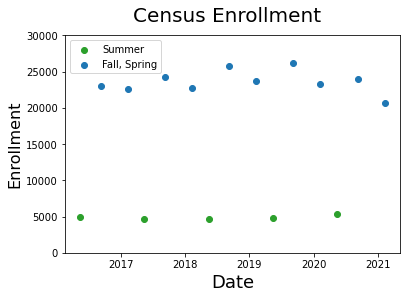

In [3]:
# Plot census enrollment over time as two series, one for summer
# and one for fall and spring
fig = plt.figure()

plt.scatter(
    census_enrollment['SU_dates'], 
    census_enrollment['SU_enrollment'], 
    c=colors[2], 
    label='Summer'
)

plt.scatter(
    census_enrollment['FA-SP_dates'], 
    census_enrollment['FA-SP_enrollment'], 
    c=colors[0], 
    label='Fall, Spring'
)

plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

There is a clear periodicity to the enrollment numbers with fall semester of a given year tending to be the highest, followed by spring and then summer. To give the simple linear regression a fighting chance, spring and summer were seperated and modeled individualy. However, for the multiple linear regression and neural network models this was not necessary.

### Model Training

The main danger associated with small datasets, especialy when employing powerfull machine learning techniques is overfitting. With a small dataset it is very easy for the model to 'memorize' the dataset. This results in perfect or near perfect predictions on the test set but yields a model which does not generalize well to unseen data and is therfore useless in real prediction tasks.

The usual strategy to combat overfitting is to divide the dataset into training, validation and testing subsets. The test data is then held in reserve to evalate the models predictive capacity after it is trained.

Due to the small size of the LMC enrollment dataset this is not possible. Instead a resampling strategy known as 'bootstrapping' was used to construct confidence intervals around model predictions. In general the training workflow was as follows (see each model's specific notebook for more details):

1. Randomly split data into training and testing sets
2. Fit model to training dataset
3. Score model with testing dataset
4. Save trained for later use in prediction
5. Repeat 100 times

This results in 100 models trained on subsets of the data and a distribution of 100 test set errors. Lets take a look at the test set error distributions now.

### Mean Absolute Test Set Prediction Error Comparision

In [4]:
# Load training results for each model

with open(f'{conf.RESULTS_PATH}{conf.SIMPLE_LINEAR_MODEL_RESULTS_FILE}', 'rb') as file:
    simple_linear_results = pickle.load(file)
    
with open(f'{conf.RESULTS_PATH}{conf.MULTIPLE_LINEAR_MODEL_RESULTS_FILE}', 'rb') as file:
    multiple_linear_results = pickle.load(file)
    
with open(f'{conf.RESULTS_PATH}{conf.NEURAL_NETWORK_RESULTS_FILE}', 'rb') as file:
    neural_network_results = pickle.load(file)

In [5]:
model_errors = list(
    zip(
        simple_linear_results['test_scores'], 
        multiple_linear_results['test_scores'], 
        neural_network_results['test_scores']
    )
)

model_errors = pd.DataFrame(model_errors, columns=[
    'Simple Linear Model', 
    'Multiple Linear Model',
    'Neural Network'
])

# model_errors.reset_index(inplace=True, drop=True)
model_errors = pd.melt(model_errors, value_vars=[
    'Simple Linear Model', 
    'Multiple Linear Model',
    'Neural Network'
])

model_errors.columns = ['Model', 'Mean absolute error']

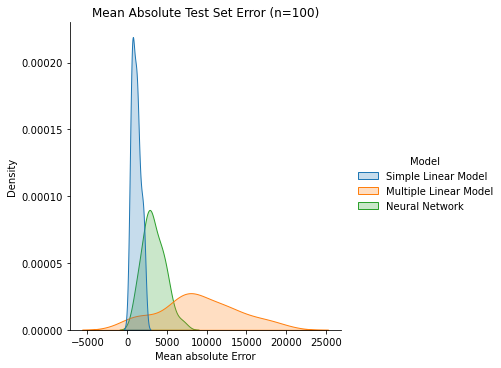

In [6]:
# Plot distribution of mean absolute error scores from each model
sns.displot(model_errors, x='Mean absolute error', hue='Model', kind='kde', fill=True)
plt.title('Mean Absolute Test Set Error (n=100)')
plt.xlabel('Mean absolute Error')
plt.ylabel('Density')
plt.show()

In [7]:
print(f'Simple linear model mean MAE: {int(np.mean(simple_linear_results["test_scores"]))}')
print(f'Multiple linear model mean MAE: {int(np.mean(multiple_linear_results["test_scores"]))}')
print(f'Neural network mean MAE: {int(np.mean(neural_network_results["test_scores"]))}')

Simple linear model mean MAE: 1161
Multiple linear model mean MAE: 9057
Neural network mean MAE: 3305


The simple linear model appears to be winning - mean absolute prediction error is lowest overall and most tightly distributed. The neural network is the runner up and the multiple linear regression model performs most poorly on this metric.

### Comparison of Predicted and Actual Enrollment Values, Test Sets

Now lets take a look at the predicted vs actual values for all of the test sets scored during the model ensemble training.

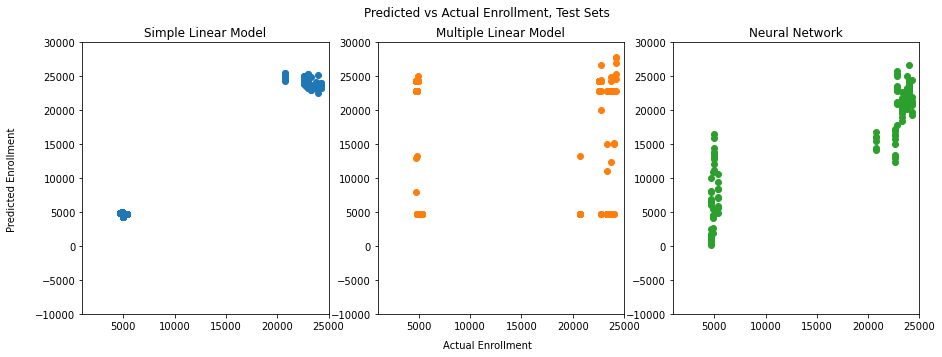

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
fig.suptitle('Predicted vs Actual Enrollment, Test Sets')

ax1.title.set_text('Simple Linear Model')
ax1.scatter(
    simple_linear_results['test_labels'], 
    simple_linear_results['test_predictions'], 
    c=colors[0]
)
ax1.set_xlim([1000, 25000])
ax1.set_ylim([-10000, 30000])

ax2.title.set_text('Multiple Linear Model')
ax2.scatter(
    multiple_linear_results['test_labels'], 
    multiple_linear_results['test_predictions'], 
    c=colors[1]
)
ax2.set_xlim([1000, 25000])
ax2.set_ylim([-10000, 30000])

ax3.title.set_text('Neural Network')
ax3.scatter(
    neural_network_results['test_labels'], 
    neural_network_results['test_predictions'], 
    c=colors[2]
)
ax3.set_xlim([1000, 25000])
ax3.set_ylim([-10000, 30000])

# Set common labels
fig.text(0.5, 0.04, 'Actual Enrollment', ha='center', va='center')
fig.text(0.06, 0.5, 'Predicted Enrollment', ha='center', va='center', rotation='vertical')

plt.show()

The actual vs predicted value scatterplots tell much the same story as the test set error distribution plot. The simple linear model's predictions cluster nicely around the diagonal indicating that the differences between actual and predicted values are small.

### Model Ensamble Predictions
The next thing to evaluate is how well the ensamble of trained models can predict the data. To do this, each model in the ensamble makes a prediction for each point in the dataset. The prediction from each model is then averaged for each point. 

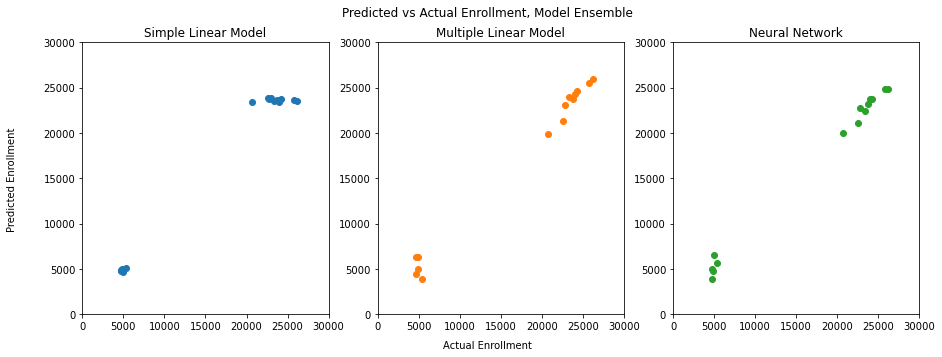

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5))
fig.suptitle('Predicted vs Actual Enrollment, Model Ensemble')

ax1.title.set_text('Simple Linear Model')
ax1.scatter(
    simple_linear_results['labels'], 
    simple_linear_results['ensamble_predictions'], 
    c=colors[0]
)
ax1.set_xlim([0, 30000])
ax1.set_ylim([0, 30000])

ax2.title.set_text('Multiple Linear Model')
ax2.scatter(
    multiple_linear_results['labels'], 
    multiple_linear_results['ensamble_predictions'], 
    c=colors[1]
)
ax2.set_xlim([0, 30000])
ax2.set_ylim([0, 30000])

ax3.title.set_text('Neural Network')
ax3.scatter(
    neural_network_results['labels'], 
    neural_network_results['ensamble_predictions'], 
    c=colors[2]
)
ax3.set_xlim([0, 30000])
ax3.set_ylim([0, 30000])

# Set common labels
fig.text(0.5, 0.04, 'Actual Enrollment', ha='center', va='center')
fig.text(0.06, 0.5, 'Predicted Enrollment', ha='center', va='center', rotation='vertical')

plt.show()

This is a somewhat surprising result! The simple linear model has been handily outperforming the other two models thus far. But the ensamble averaged predictions from the neural network and multiple linear model are visualy much more diagonal than the simple linear model.

### Confidence intervals
The last direct comparision to make is the width of the confidence intervals generated by the bootstrapping approach employed by all three models.